In [1]:
import os
import pickle
import numpy as np

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
niter = 3
ibatch = 0

# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
# load true continuum
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

# load SpenderQ recon wavelength
w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)

In [4]:
recons = []

recons.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.recons.npy' % (niter, ibatch)))
recons.append(np.load('/tigress/chhahn/spender_qso/train/london.rebin.sigma2.iter%i_%i.recons.npy' % (niter, ibatch)))
recons.append(np.load('/tigress/chhahn/spender_qso/train/london.rebin.sigma1.iter%i_%i.recons.npy' % (niter, ibatch)))

recons = np.array(recons)

In [5]:
# select high-z and bright (high normalization) quasars
highzs = np.arange(len(z))[(z > 3.) & (norm > 2.)][:4]

In [7]:
# continuum residual over full wavelength
wave_rest_rebin = np.linspace(800, 3000, 2000)

dcont_recon, dfcont_recon = [], []

for igal in range(len(z)): 
    wlim = (wave_rest_rebin > 3.6e3/float(1+z[igal])) & ((wave_rest_rebin < 9.9e3/float(1+z[igal])))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    _dcont, _dfcont = [], []
    for recon in recons: 
        # rebin reconstruction
        recon_rebin = U.trapz_rebin(
            w_recon, 
            recon[igal], 
            xnew=wave_rest_rebin[wlim])
    
        # residual
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dcont[wlim] = true_rebin - recon_rebin 
    
        # fractional residual
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont[wlim] = (true_rebin - recon_rebin)/true_rebin
        _dcont.append(dcont)
        _dfcont.append(dfcont)  
        
    dcont_recon.append(np.array(_dcont))
    dfcont_recon.append(np.array(_dfcont))
    
dcont_recon = np.array(dcont_recon)
dfcont_recon = np.array(dfcont_recon)

In [9]:
# spenderq performance on QSO with picca 
dcont_q = np.zeros((3, len(wave_rest_rebin), 5))
dfcont_q = np.zeros((3, len(wave_rest_rebin), 5))
for imodel in range(recons.shape[0]): 
    for i in np.arange(len(wave_rest_rebin)): 
        has_spectra = (dcont_recon[:,imodel,i] != -999.)

        if np.sum(has_spectra): 
            dcont_q[imodel,i,:] = np.quantile(dcont_recon[:,imodel,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
            dfcont_q[imodel,i,:] = np.quantile(dfcont_recon[:,imodel,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])     

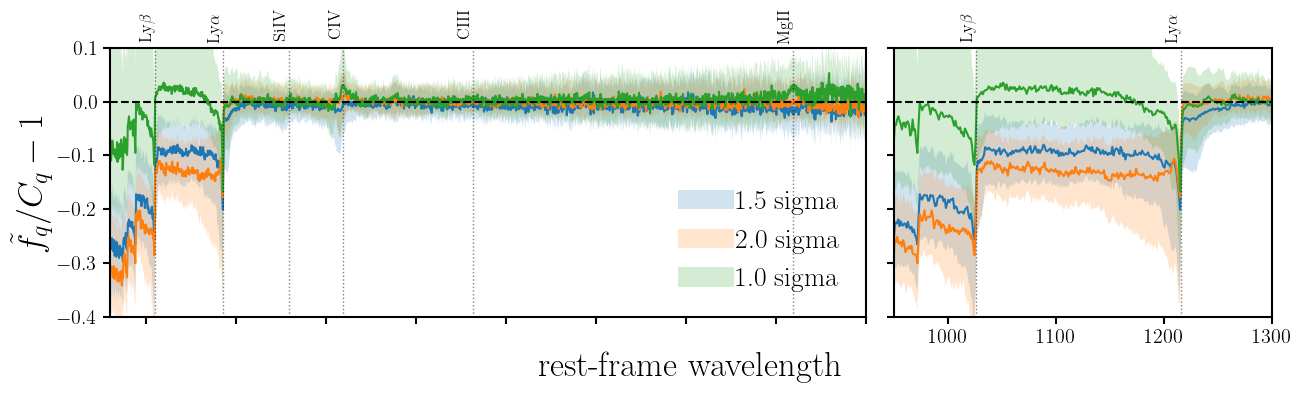

In [14]:
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

# fractional residual
sub = plt.subplot(gs[0])

# SpenderQ
for imodel in range(3): 
    sub.fill_between(wave_rest_rebin, -dfcont_q[imodel,:,1], -dfcont_q[imodel,:,3], 
                     color='C%i' % imodel, edgecolor='none', alpha=0.2, label='%.1f sigma ' % [1.5, 2, 1][imodel])
    sub.plot(wave_rest_rebin, -dfcont_q[imodel,:,2], color='C%i' % imodel)

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

sub.text(1026, 0.16, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.16, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1397.61, 0.17, r'SiIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1549.48, 0.17, r'CIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1908.73, 0.17, r'CIII', rotation=90., ha='right', va='top', fontsize=12)
sub.text(2799.12, 0.17, r'MgII', rotation=90., ha='right', va='top', fontsize=12)

sub.legend(loc='lower right', handletextpad=0.1, fontsize=20)
sub.set_xlim(900., 3000.)
sub.set_xticklabels([])
sub.set_ylabel(r'$\tilde{f}_q/C_q - 1$', fontsize=25)
sub.set_ylim(-0.4, 0.1)

sub = plt.subplot(gs[1])

# SpenderQ
for imodel in range(3): 
    sub.fill_between(wave_rest_rebin, -dfcont_q[imodel,:,1], -dfcont_q[imodel,:,3], 
                     color='C%i' % imodel, edgecolor='none', alpha=0.2, label='SpenderQ')
    sub.plot(wave_rest_rebin, -dfcont_q[imodel,:,2], color='C%i' % imodel)
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.16, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.16, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
sub.set_ylim(-0.4, 0.1)
sub.set_yticklabels([])
fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel('rest-frame wavelength', fontsize=25)
plt.savefig('sigma_test.pdf', bbox_inches='tight')

In [81]:
dspec, dspec_lya, dspec_lyb = [], [], []
for igal in range(len(spec)): 
    snr = np.array(spec)[igal] * np.array(w)[igal]**-0.5
    
    wlim = np.array(models[0].wave_obs) < 1215 * (1+np.array(z)[igal])
    
    dw = np.clip(8.0 / np.median(snr[wlim]), 4.0, 16.)

    if dw == 0.: continue
    w_rebin = np.linspace(3600, 9824., int((9824.-3600.)/dw))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=w_rebin[1:-1])
    spec_rebin = U.trapz_rebin(
        np.array(models[0].wave_obs), 
        np.array(spec[igal]), 
        xnew=w_rebin[1:-1])
    ivar_rebin = U.trapz_rebin(
        np.array(models[0].wave_obs), 
        np.array(w[igal]/np.gradient(np.array(models[0].wave_obs))), 
        xnew=w_rebin[1:-1]) * dw

    wlim = (w_rebin[1:-1] > 1215 * (1 + np.array(z)[igal]))
    dspec.append(((true_rebin - spec_rebin) * ivar_rebin**0.5)[wlim])
    
    wlim = (w_rebin[1:-1] > 1026 * (1 + np.array(z)[igal])) & (w_rebin[1:-1] < 1215 * (1 + np.array(z)[igal]))
    dspec_lya.append(((true_rebin - spec_rebin) * ivar_rebin**0.5)[wlim])
    
    wlim = (w_rebin[1:-1] < 1026 * (1 + np.array(z)[igal]))
    dspec_lyb.append(((true_rebin - spec_rebin) * ivar_rebin**0.5)[wlim])    

dspec = np.concatenate(dspec)
dspec_lya = np.concatenate(dspec_lya)
dspec_lyb = np.concatenate(dspec_lyb)

/tmp/ipykernel_2375602/261204684.py:3: RuntimeWarning: divide by zero encountered in power
  snr = np.array(spec)[igal] * np.array(w)[igal]**-0.5
/tmp/ipykernel_2375602/261204684.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.array(w[igal]/np.gradient(np.array(models[0].wave_obs))),


(-5.0, 10.0)

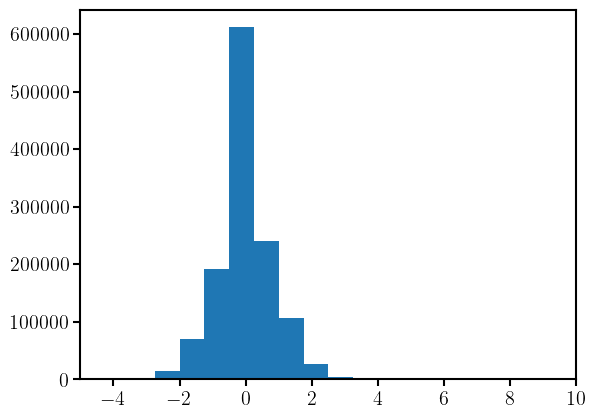

In [82]:
plt.hist(dspec, range=(-5, 10), bins=20)
plt.xlim(-5, 10)

In [95]:
print('%.1f percent of spectral elements have absorption' % (100.*(1. - 2.* np.mean(dspec < 0))))

23.6 percent of spectral elements have absorption


In [97]:
np.mean(np.array(w) == 0)

np.float64(0.2729746337231718)

(-5.0, 10.0)

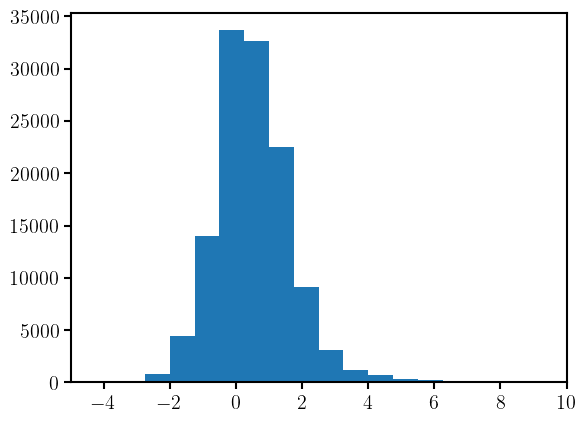

In [84]:
plt.hist(dspec_lya, range=(-5, 10), bins=20)
plt.xlim(-5, 10)

In [93]:
print('%.1f percent of spectral elements have absorption' % (100.*(1. - 2.* np.mean(dspec_lya < 0))))

42.6 percent of spectral elements have absorption


(-5.0, 10.0)

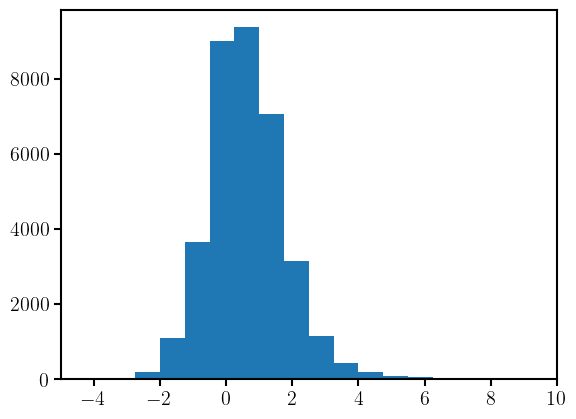

In [86]:
plt.hist(dspec_lyb, range=(-5, 10), bins=20)
plt.xlim(-5, 10)

In [94]:
print('%.1f percent of spectral elements have absorption' % (100.*(1. - 2.* np.mean(dspec_lyb < 0))))

46.8 percent of spectral elements have absorption


In [5]:
ibatch = 0
for niter in range(4): 
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
        _, _w, _, _, _, _ = pickle.load(f)
        
    print(np.mean(np.array(_w == 0.)))

0.27768550294788585
0.2692796103890888
0.2716229336685516
0.2729746337231718


In [ ]:
niter = 3
ibatch = 0

# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
# load true continuum
true_cont = np.load('/tigress/chhahn/sddpender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

# load SpenderQ recon wavelength
w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)